<a href="https://colab.research.google.com/github/MalkovGN/toxic_comments_filter/blob/main/ToxicComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# Загружаем тестовый набор данных и создаем бинарный label

# Оборачиваем все в кавычки, чтобы не было проблем с токенизацией
train_data = pd.read_csv("train.csv", quoting=csv.QUOTE_ALL)

train_data['label'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

Анализ данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

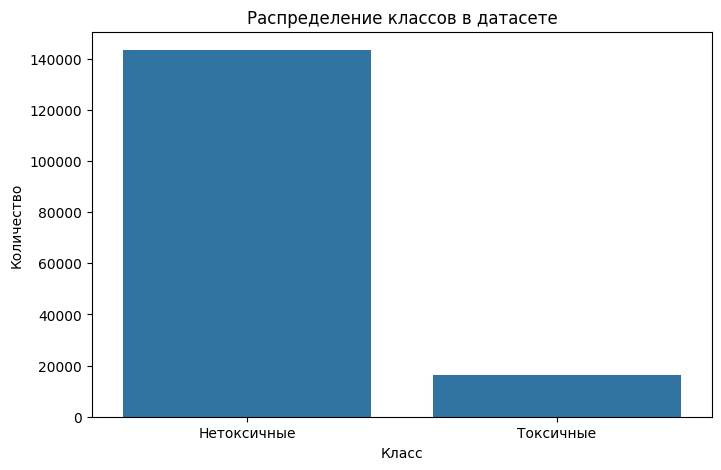

In [ ]:
# Распеределение меток

plt.figure(figsize=(8, 5))
sns.countplot(x=train_data['label'])
plt.title("Распределение классов в датасете")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'])
plt.savefig("label_distribution.png")
plt.show()

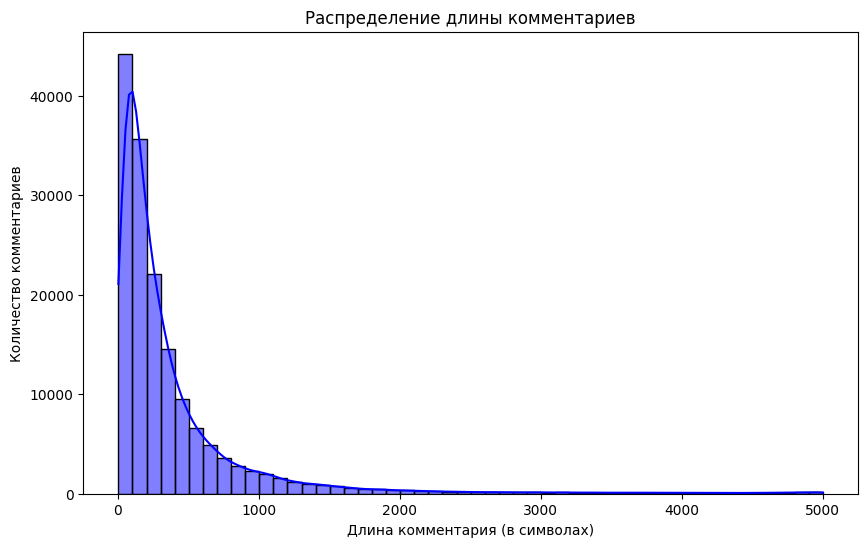

In [ ]:
# Длина комментариев

train_data['comment_length'] = train_data['comment_text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='comment_length', bins=50, kde=True, color='blue')
plt.title("Распределение длины комментариев")
plt.xlabel("Длина комментария (в символах)")
plt.ylabel("Количество комментариев")
plt.savefig("comment_length_distribution.png")
plt.show()


In [ ]:
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


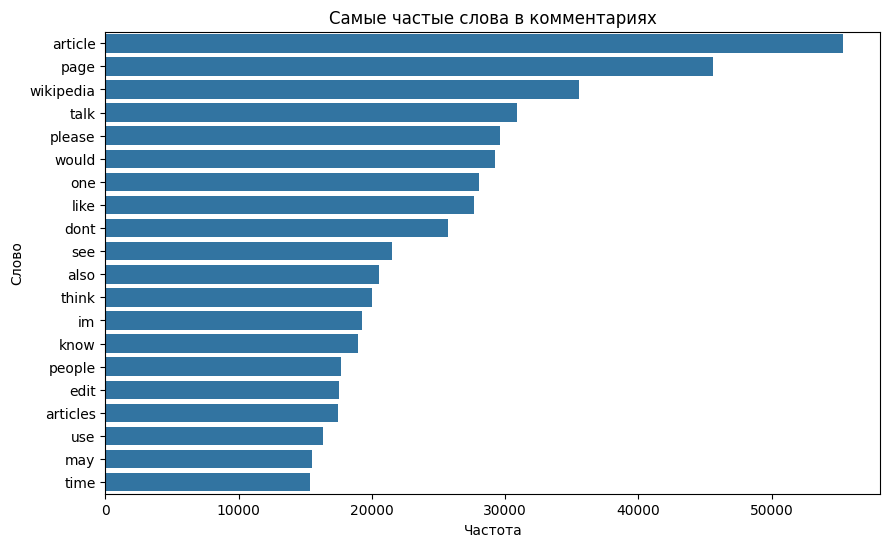

In [ ]:
# Частота слов

nltk.download('stopwords')
# Функция для токенизации текста
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
    return [word for word in tokens if word not in stop_words]

# Токенизация всех текстов
all_words = []
for comment in train_data['comment_text']:
    all_words.extend(preprocess_text(comment))

# Частота слов
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

# График
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Самые частые слова в комментариях")
plt.xlabel("Частота")
plt.ylabel("Слово")
plt.savefig("word_frequency.png")
plt.show()

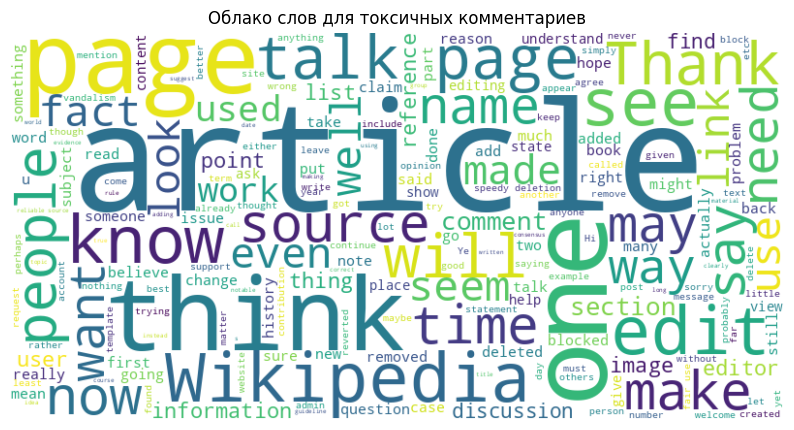

In [ ]:
# Облако слов для нетоксичных комментариев
untoxic_comments = train_data[train_data['label'] == 0]['comment_text']
untoxic_words = ' '.join(untoxic_comments)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(untoxic_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Облако слов для нетоксичных комментариев")
plt.savefig("untoxic_wordcloud.png")
plt.show()

In [ ]:
# Разделение данных на тренировочные и валидационные

X_train, X_val, y_train, y_val = train_test_split(train_data['comment_text'], train_data['label'], test_size=0.2, random_state=42)

In [ ]:
# Определение токенайзера

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Для повышения читаемости кода создаем класс для подачи данных в DistilBERT

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Создаем DataLoader для тренировки и валидации

train_dataset = ToxicCommentsDataset(X_train, y_train, tokenizer)
val_dataset = ToxicCommentsDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
# Модель DistilBERT

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Оптимизатор

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
# Функция оценки модели
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    print("Классификационный отчет:")
    print(classification_report(all_labels, all_preds))

In [ ]:
# Функция обучения

def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        print(f"Эпоха {epoch+1}/{epochs}")
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Средняя потеря: {total_loss / len(train_loader):.4f}, Точность: {correct / total:.4f}")

        # Оценка на валидации
        evaluate_model(model, val_loader, device)

In [ ]:
# Обучение модели

train_model(model, train_loader, val_loader, optimizer, device, epochs=3)

Эпоха 1/3
Средняя потеря: 0.0850, Точность: 0.9690
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28671
           1       0.83      0.83      0.83      3244

    accuracy                           0.97     31915
   macro avg       0.90      0.91      0.91     31915
weighted avg       0.97      0.97      0.97     31915

Эпоха 2/3
Средняя потеря: 0.0560, Точность: 0.9792
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     28671
           1       0.87      0.79      0.82      3244

    accuracy                           0.97     31915
   macro avg       0.92      0.89      0.90     31915
weighted avg       0.97      0.97      0.97     31915

Эпоха 3/3
Средняя потеря: 0.0308, Точность: 0.9895
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28671
         

Тестирование модели

In [ ]:
# Загрузка данных

test_data = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")

In [ ]:
# Фильтрация строк с нерелевантными метками (-1)
test_labels = test_labels[test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1) != -1]

# Создание бинарной метки `label` на основе шести других меток
test_labels['label'] = test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


In [ ]:
# Объединение данных и меток по идентификатору
test_data = test_data.merge(test_labels[['id', 'label']], on='id', how='inner')

# Тексты и метки
X_test = test_data['comment_text']
y_test = test_data['label']

In [ ]:
# Токенизация тестовых данных
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# Токенизированные входные данные
input_ids_test = encoded_test['input_ids']
attention_mask_test = encoded_test['attention_mask']

In [ ]:
# Перенос данных на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids_test = input_ids_test.to(device)
attention_mask_test = attention_mask_test.to(device)

# Перенос модели на устройство
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Создание датасета
test_dataset = ToxicCommentsDataset(
    texts=X_test,  # Тексты из тестового набора
    labels=y_test,  # Метки из тестового набора
    tokenizer=tokenizer,
    max_length=128
)

In [ ]:
# Создание DataLoader с уменьшенным batch_size
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Прогон через модель
predictions = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

In [ ]:
# Оценка модели
from sklearn.metrics import classification_report, accuracy_score

print("Классификационный отчет:")
print(classification_report(y_test, predictions))

print("Точность:", accuracy_score(y_test, predictions))

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     59445
           1       0.41      0.93      0.57      4533

    accuracy                           0.90     63978
   macro avg       0.70      0.91      0.76     63978
weighted avg       0.95      0.90      0.92     63978

Точность: 0.900715871080684


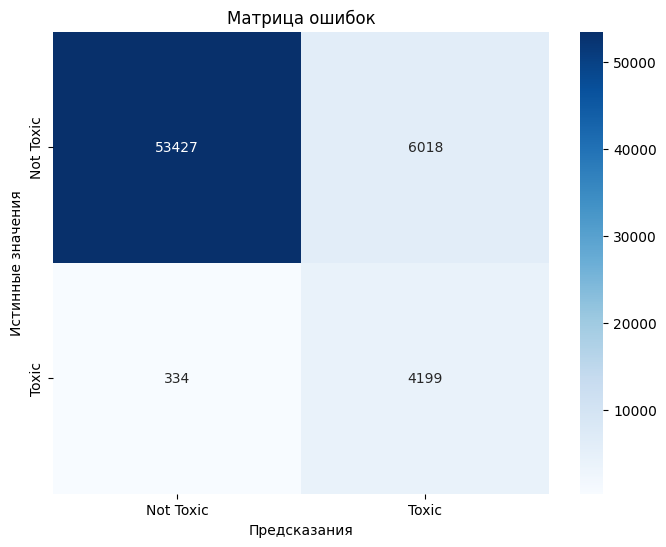

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Матрица ошибок
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
plt.title("Матрица ошибок")
plt.xlabel("Предсказания")
plt.ylabel("Истинные значения")
plt.show()

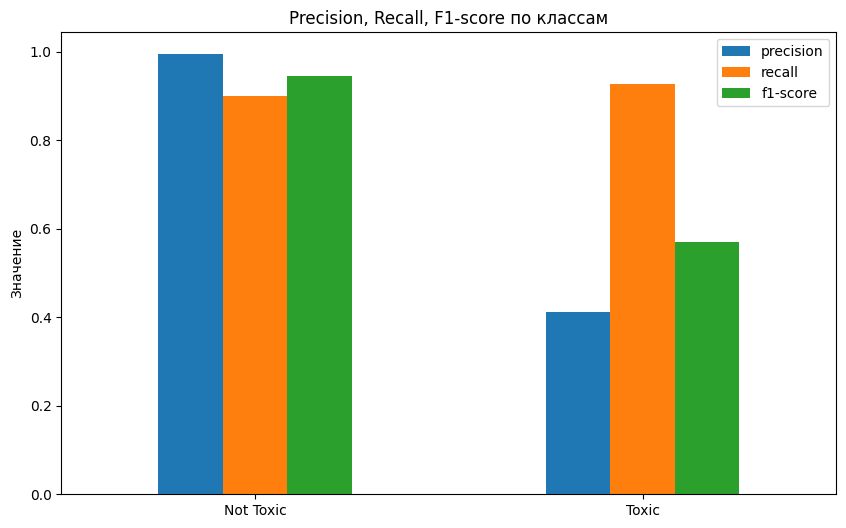

In [ ]:

# Precision, Recall, F1-score для каждого класса
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# График Precision, Recall, F1-score
df_metrics = df_report.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
df_metrics.index = ["Not Toxic", "Toxic"]
df_metrics.plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, F1-score по классам")
plt.ylabel("Значение")
plt.xticks(rotation=0)
plt.show()

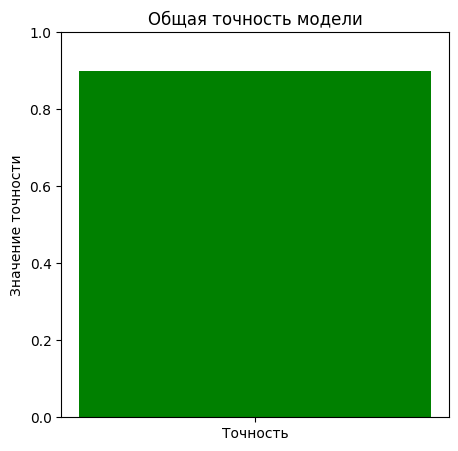

In [ ]:
# 3. Общая точность (Accuracy)
accuracy = accuracy_score(y_test, predictions)
plt.figure(figsize=(5, 5))
plt.bar(["Точность"], [accuracy], color='green')
plt.title("Общая точность модели")
plt.ylim(0, 1)
plt.ylabel("Значение точности")
plt.savefig("accuracy_bar_chart.png")  # Сохранение графика
plt.show()